[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/VectorInstitute/rag-bootcamp/blob/main/implementations/cloud_search/s3_search_llamaindex.ipynb)

# Amazon AWS S3 Search with LlamaIndex

This example shows how to use the Python [LlamaIndex](https://www.llamaindex.ai/) to run a text-generation request on open-source LLMs and embedding models using the OpenAI SDK, then augment that request using documents stored in an Amazon AWS S3 bucket.

### 📝 Requirements

To run this notebook, you will need:

- **OpenAI API key**:  
    - Sign up at [OpenAI](https://platform.openai.com/) and create an API key
- **AWS credentials ([Documentation](https://docs.aws.amazon.com/general/latest/gr/aws-sec-cred-types.html))**:  
    - AWS Access Key ID  
    - AWS Secret Access Key  

- **Amazon S3 bucket ([Documentation](https://docs.aws.amazon.com/AmazonS3/latest/userguide/upload-objects.html))**:  
    - A bucket containing the [Vector Institute 2021-22 Annual Report (PDF)](https://vectorinstitute.ai/wp-content/uploads/2023/05/vector-institute-2021-22-annual-report_accessible.pdf)  


## Set up the RAG workflow environment

#### Install libraries (Only in Google Colab)

In [ ]:
import os

if "COLAB_RELEASE_TAG" in os.environ:
    # This is a Google Colab environment
    # Install required dependencies
    !pip3 install numpy==1.26.4 torchvision==0.16.2 faiss-cpu llama-index llama-index-core llama-index-embeddings-huggingface llama-index-llms-openai-like llama-index-vector-stores-faiss aieng-rag-utils
    # Uninstall conflicting dependencies in the Colab environment
    !pip3 uninstall --yes torchao torchaudio torchdata torchsummary torchtune

#### Import libraries

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import faiss
import os

from aieng.rag.utils import get_device_name
from aieng.rag.utils.search import DocumentReader, pretty_print

from llama_index.core import VectorStoreIndex, Settings, StorageContext
from llama_index.core.llms import ChatMessage
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.openai_like import OpenAILike
from llama_index.vector_stores.faiss import FaissVectorStore

#### Load OpenAI env variables

In [4]:
OPENAI_BASE_URL = os.getenv("OPENAI_BASE_URL", "https://api.openai.com/v1")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "YOUR_OPENAI_API_KEY")
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID", "YOUR_AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY", "YOUR_AWS_SECRET_ACCESS_KEY")

#### Choose LLM and embedding model

In [5]:
GENERATOR_MODEL_NAME = "gpt-4.1"
EMBEDDING_MODEL_NAME = "BAAI/bge-base-en-v1.5"

## Start with a basic generation request without RAG augmentation

Let's start by asking Llama-3.1 a difficult, domain-specific question we don't expect it to have an answer to. A simple question like "*What is the capital of France?*" is not a good question here, because that's world knowledge that we expect the LLM to know.

Instead, we want to ask it a question that is domain-specific and it won't know the answer to. A good example would be an obscure detail buried deep within a company's annual report. For example:

*How many Vector scholarships in AI were awarded in 2022?*

In [6]:
query = "How many Vector scholarships in AI were awarded in 2022?"

## Now send the query to the open source model using KScope

In [7]:
llm = OpenAILike(
    model=GENERATOR_MODEL_NAME,
    is_chat_model=True,
    temperature=0,
    max_tokens=None,
    api_base=OPENAI_BASE_URL,
    api_key=OPENAI_API_KEY,
)
message = [ChatMessage(role="user", content=query)]
try:
    result = llm.chat(message)
    print(f"Result: \n\n{result}")
except Exception as err:
    if "Error code: 503" in err.message:
        print(f"The model {GENERATOR_MODEL_NAME} is not ready yet.")
    else:
        raise

Result: 

assistant: In 2022, the **Vector Institute** awarded **107 Vector Scholarships in Artificial Intelligence (VSAI)** to students beginning eligible AI-related master’s programs at Ontario universities.


Without additional information, the model is unable to answer the question correctly. **Vector in fact awarded 109 AI scholarships in 2022.** Fortunately, we do have that information available in Vector's 2021-22 Annual Report, which is available in AWS S3 bucket. Let's see how we can use RAG to augment our question with a document search (stored in S3) and get the correct answer.

## Ingestion: Retrieve and store the documents from an Amazon S3 bucket

We've added Vector's 2021-22 Annual Report pdf in an Amazon S3 bucket:

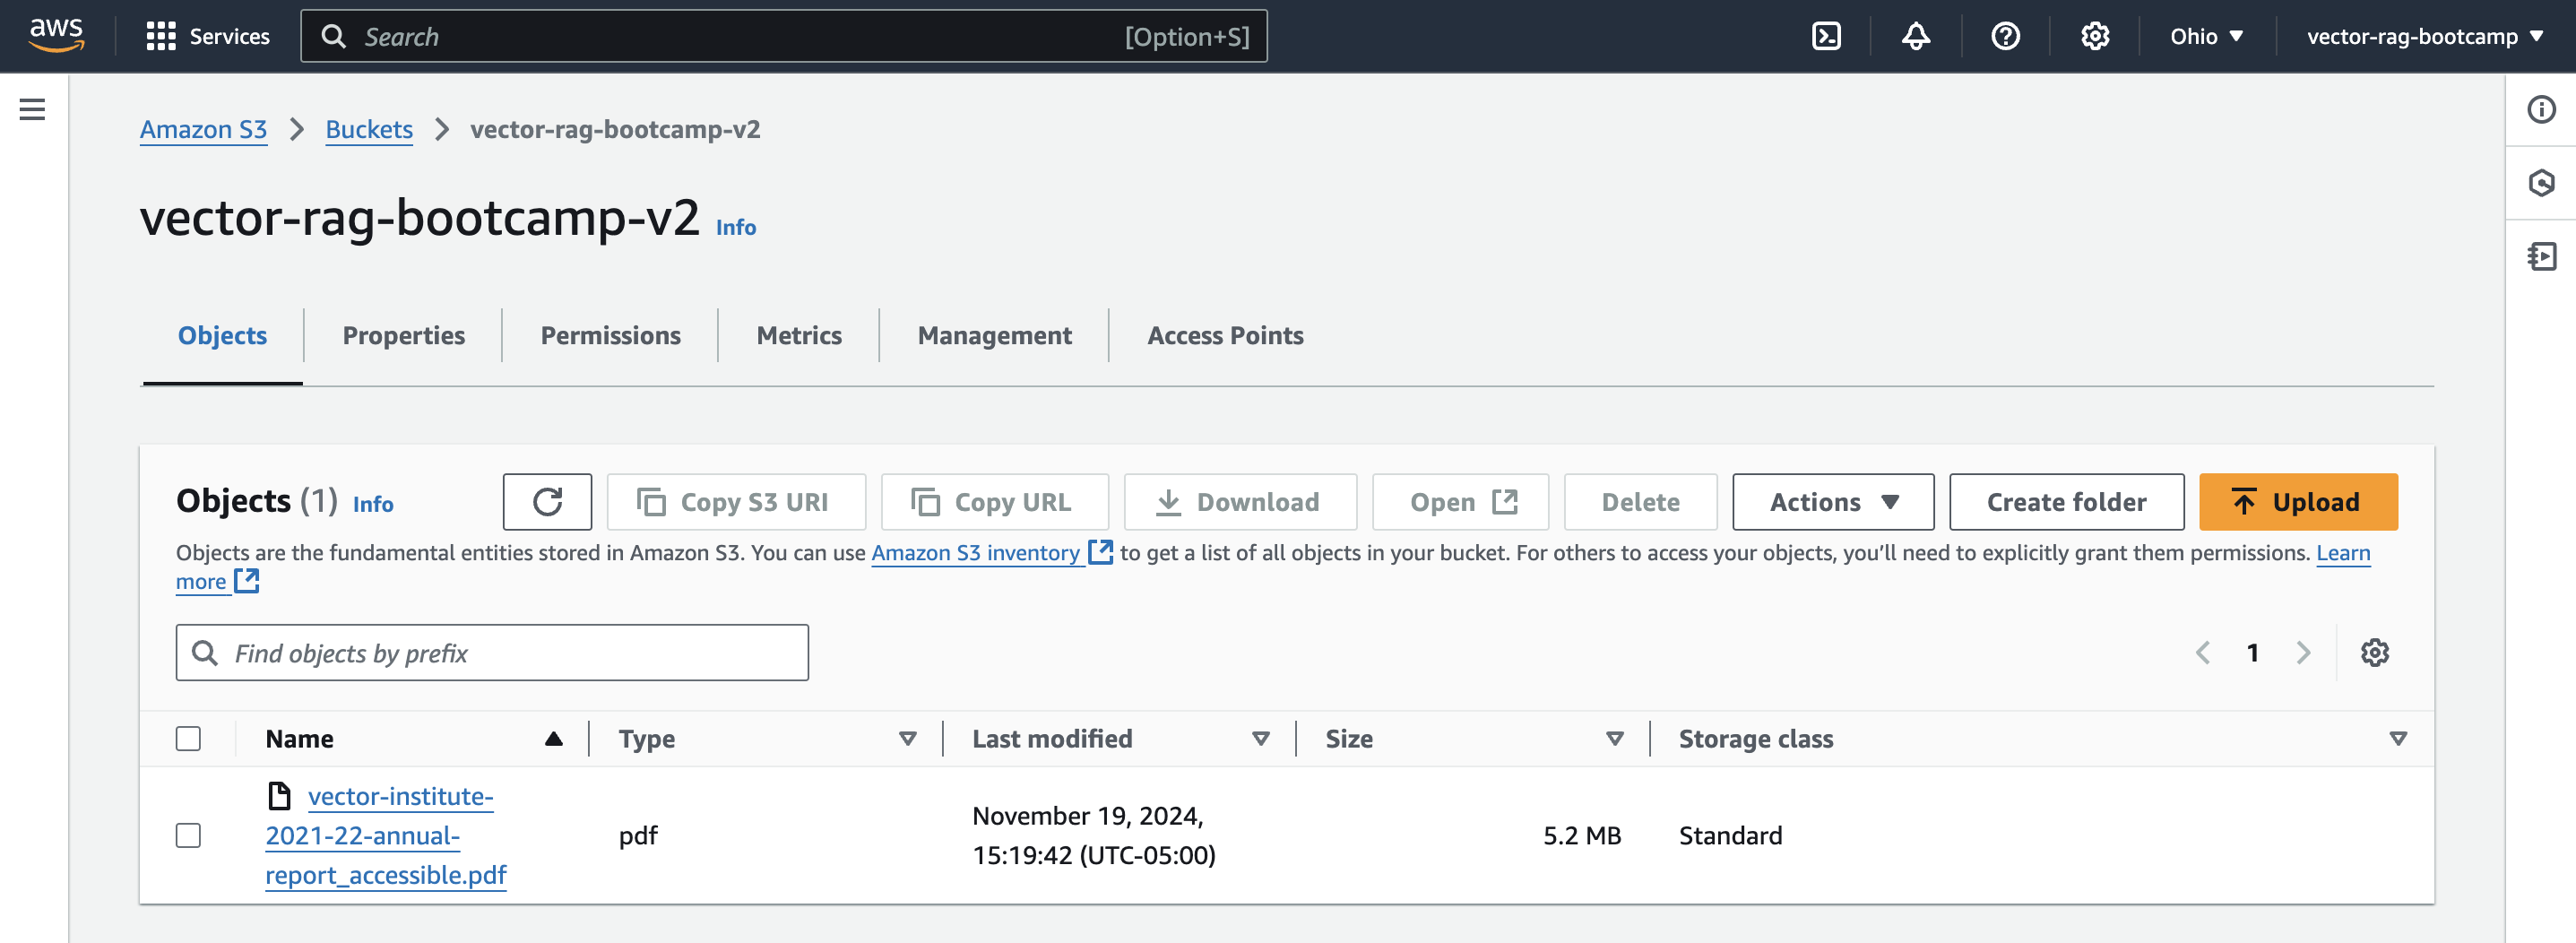

#### Load these documents using S3Reader

Fortunately, there is a simple S3 utility available via [LlamaHub](https://www.llamahub.ai/), a registry of open-source data connectors that you can easily plug into any LlamaIndex application.

In [8]:
doc_reader = DocumentReader(
    s3_bucket="vector-rag-bootcamp-v2",
    aws_access_id=AWS_ACCESS_KEY_ID,
    aws_access_secret=AWS_SECRET_ACCESS_KEY,
    create_nodes=True,
)

docs, chunks = doc_reader.load()
print(f"Number of source documents: {len(docs)}")

Number of source documents: 42


In [9]:
print(f"Number of text chunks: {len(chunks)}")

Number of text chunks: 196


#### Define the embeddings model

In [10]:
device = get_device_name()

print("Setting up the embeddings model...")
embeddings = HuggingFaceEmbedding(
    model_name=EMBEDDING_MODEL_NAME,
    device=device,
    trust_remote_code=True,
)

Setting up the embeddings model...


#### Set LLM and embedding model [recommended for LlamaIndex]

In [11]:
Settings.llm = llm
Settings.embed_model = embeddings

## Retrieval: Make the document chunks available via a retriever

The retriever will identify the document chunks that most closely match our original query. (This takes about 1-2 minutes)

In [12]:
def get_embed_model_dim(embed_model):
    embed_out = embed_model.get_text_embedding("Dummy Text")
    return len(embed_out)


faiss_dim = get_embed_model_dim(embeddings)
faiss_index = faiss.IndexFlatL2(faiss_dim)

vector_store = FaissVectorStore(faiss_index=faiss_index)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

index = VectorStoreIndex(chunks, storage_context=storage_context)

In [13]:
retriever = index.as_retriever(similarity_top_k=10)

# Retrieve the most relevant context from the vector store based on the query
retrieved_docs = retriever.retrieve(query)

Let's see what results it found. Important to note, these results are in the order the retriever thought were the best matches.

In [14]:
# Print the retrieved documents
pretty_print(retrieved_docs)

Document 1:

26 
 
 
VECTOR SCHOLARSHIPS IN 
AI ATTRACT TOP TALENT 
TO ONTARIO UNIVERSITIES 
109 
Vector Scholarships in AI awarded 
34 
Programs 
13 
Universities 
351 
Scholarships awarded since the 
program launched in 2018 
Supported with funding from the Province of 
Ontario, the Vector Institute Scholarship in Artifcial 
Intelligence (VSAI) helps Ontario universities to attract 
the best and brightest students to study in AI-related 
master’s programs. 
Scholarship recipients connect directly with leading
----------------------------------------------------------------------------------------------------
Document 2:

5 
Annual Report 2021–22Vector Institute
SPOTLIGHT ON FIVE YEARS OF AI 
LEADERSHIP FOR CANADIANS 
SINCE THE VECTOR INSTITUTE WAS FOUNDED IN 2017: 
2,080+ 
Students have graduated from 
Vector-recognized AI programs and 
study paths 
$6.2 M 
Scholarship funds committed to 
students in AI programs 
3,700+ 
Postings for AI-focused jobs and 
internships ofered on Vector’

## Now send the query to the RAG pipeline

In [15]:
query_engine = RetrieverQueryEngine(retriever=retriever)
result = query_engine.query(query)
print(f"Result: \n\n{result}")

Result: 

In 2022, 109 Vector Scholarships in AI were awarded.


The model provides the correct answer (109) using the retrieved information.